# Setup

In [2]:
#@title #**Setup:** Imports and dependencies
#@markdown Install and import Python dependencies.
location = 'vsc' #@param['colab', 'vsc']

package = 'inseq' #@param['inseq', 'kayo', 'both']

!pip install jsonlines
import jsonlines
import json

from transformers import GPT2Tokenizer, GPT2LMHeadModel
import copy
import sys
import torch
from IPython.display import clear_output
import numpy as np
import gc
import argparse
from collections import defaultdict
import pandas as pd
import matplotlib as plt

import random
random.seed(42)

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

if package == 'inseq' or package == 'both':
  print('Installing dependencies inseq')
  !pip install inseq
  import inseq


if package == 'kayo' or package == 'both':
  print('Installing dependencies kayo')
  !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
  # !git clone https://github.com/JanAthmer/Baseline_clusters.git &> /dev/null
  !git clone https://github.com/kayoyin/interpret-lm.git &> /dev/null
  # sys.path.append('./Baseline_clusters')
  sys.path.append('./interpret-lm')

  from lm_saliency import *

clear_output()

print('Done!')

Done!


In [3]:
#@title #**Setup:** load Drive
if location == 'colab':
  from google.colab import drive
  drive.mount('/content/drive')

In [4]:
#@title #**Utils:** reciprocal_rank, average

def average(lst):
  return sum(lst)/len(lst)


def reciprocal_rank(predictions, targets):
    # Combine predictions and targets into pairs
    pairs = list(zip(predictions, targets))

    # Sort the pairs based on the prediction values (in descending order)
    sorted_pairs = sorted(pairs, key=lambda x: x[0], reverse=True)

    # Find the rank of the first correct prediction
    rank = next((i + 1 for i, (pred, target) in enumerate(sorted_pairs) if target), 0)

    # Calculate reciprocal rank
    reciprocal_rank = 1 / rank if rank > 0 else 0

    return reciprocal_rank

def get_target(sentence):
    b = sentence.split(' ')
    prefix_l = 0
    postix_l = 0
    target_l = 0
    check = False
    for i,word in enumerate(b):
        if i != 0:
            word = " "+word

        if check == True:
            postix_l += len(tokenizer(word)['input_ids'])
        if "n't" in word:
            target_l = len(tokenizer(word)['input_ids'])
            check = True
        if check == False:
            prefix_l += len(tokenizer(word)['input_ids'])
    return([False]*prefix_l+[True]*target_l+[False]*postix_l)

import random

def generate_one_hot_list(length):
    # Check if the length is valid
    if length <= 0:
        raise ValueError("Length must be greater than 0")

    # Choose a random index for the "hot" element
    hot_index = random.randint(0, length - 1)

    # Create the one-hot list
    one_hot_list = [0] * length
    one_hot_list[hot_index] = 1

    return one_hot_list

def get_last_true_index(one_hot_vector):
    """
    Get the index of the last True value in the one-hot vector.

    Parameters:
    one_hot_vector (list of bool): One-hot vector with possibly multiple True values.

    Returns:
    int: The index of the last True value in the one-hot vector, or -1 if no True values are found.
    """
    last_true_index = -1
    for i, value in enumerate(one_hot_vector):
        if value:
            last_true_index = i
    return last_true_index

def normalize_vector(vector):
    """
    Normalize a vector between -1 and 1 by dividing each element by the absolute maximum value.

    Args:
    vector (list or numpy array): The input vector to be normalized.

    Returns:
    list or numpy array: The normalized vector.
    """
    abs_max = max(abs(max(vector)), abs(min(vector)))
    normalized_vector = [element / abs_max for element in vector]
    return normalized_vector

# Table run

In [5]:
with jsonlines.open("npi_present_1.jsonl", 'r') as f:
  dataframe_npi = pd.DataFrame(f)

with jsonlines.open("determiner_noun_agreement_1.jsonl", 'r') as f:
  dataframe_dna = pd.DataFrame(f)

sentences = []
values = []
with open("prefix+value.tsv", 'r', encoding='utf-8') as ifh:
  for line in ifh:
      sentence, value = line.strip().split('\t')
      sentences.append(sentence)
      values.append(value)
print(sentence,value)

We don't want to raise 3.671572208404541


In [ ]:
#@title #**Loop through 'ANY' NPI and give MRR**
import torch
explanation = "lime" #"input_x_gradient", "integrated_gradients", "lime", "deeplift", "gradient_shap","discretized_integrated_gradients"
attributed_fns = ["logit","probability"] #@param ["logit", "probability", "entropy", "crossentropy", "perplexity", "pcxmi", "kl_divergence", "in_context_pvi", "mc_dropout_prob_avg", "top_p_size"]
revs = ["True", "False"]
# normalize = ["True", "False"]

model_inseq = inseq.load_model("gpt2", explanation)

base_l = []
base_p = []

contrast_l_T = []
contrast_l_F = []
contrast_p_T = []
contrast_p_F = []

contrast_rnd_l_T = []
contrast_rnd_l_F = []
contrast_rnd_p_T = []
contrast_rnd_p_F = []



i = 0

for attributed_fn in attributed_fns:
    
    base = False
    
    if attributed_fn == 'logit':
        contrast_attributed_fn = "contrast_logits_diff"
    if attributed_fn == 'probability':
        contrast_attributed_fn = "contrast_prob_diff"
        
    for rev in revs:
        i += 1
        print(i)
#         for index, row in dataframe_npi.iterrows():
#             print(index)
#             sentence = row["one_prefix_prefix"]
#             target = row["one_prefix_word_good"]
#             foil = row["one_prefix_word_bad"]
#             foil_rnd = "hello"
            
        for sentence in sentences:
            i += 1

            target = "any"
            foil = "some"
            foil_rnd = "hello"
            
            if base == False:
                baseline = model_inseq.attribute(
                    sentence,
                    sentence + " " + target,
                    attributed_fn=attributed_fn,
                )

            if rev == 'False':
                contrast = model_inseq.attribute(
                  sentence,
                  sentence + " " + target,
                  attributed_fn= contrast_attributed_fn,
                  contrast_targets= sentence + " " + foil,
                  step_scores=[contrast_attributed_fn]
                )
                
                contrast_rnd = model_inseq.attribute(
                  sentence,
                  sentence + " " + target,
                  attributed_fn= contrast_attributed_fn,
                  contrast_targets= sentence + " " + foil_rnd,
                  step_scores=[contrast_attributed_fn]
                )
                
            if rev == 'True':
                contrast = model_inseq.attribute(
                  sentence,
                  sentence + " " + foil,
                  attributed_fn= contrast_attributed_fn,
                  contrast_targets= sentence + " " + target,
                  step_scores=[contrast_attributed_fn]
                )
                
                contrast_rnd = model_inseq.attribute(
                  sentence,
                  sentence + " " + foil_rnd,
                  attributed_fn= contrast_attributed_fn,
                  contrast_targets= sentence + " " + target,
                  step_scores=[contrast_attributed_fn]
                )
            
            
            

            clear_output()

            base_tensor = baseline[0].target_attributions
            contrastive_tensor = contrast[0].target_attributions
            contrastive_rnd_tensor = contrast_rnd[0].target_attributions

            baseline_att = base_tensor.sum(axis = 2)
            contrast_att = contrastive_tensor.sum(axis = 2)
            contrast_rnd_att = contrastive_rnd_tensor.sum(axis = 2)

            baseline_att = torch.flatten(baseline_att[~torch.any(baseline_att.isnan(),dim=1)]).numpy()
            contrast_att = torch.flatten(contrast_att[~torch.any(contrast_att.isnan(),dim=1)]).numpy()
            contrast_rnd_att = torch.flatten(contrast_rnd_att[~torch.any(contrast_rnd_att.isnan(),dim=1)]).numpy()

            targets = get_target(sentence)
#             sent_len = len(tokenizer(sentence)['input_ids'])
#             targets = [True] + [False] * (sent_len - 1)
#             targets = [False] * (sent_len - 1)+[True]

            
            base_mmr = reciprocal_rank(baseline_att, targets)
            contrast_mmr = reciprocal_rank(contrast_att, targets)
            contrast_rnd_mmr = reciprocal_rank(contrast_rnd_att, targets)
            
            if rev == 'True':
                if attributed_fn == 'logit':
                    contrast_l_T.append(contrast_mmr)
                    contrast_rnd_l_T.append(contrast_mmr)
                    
                elif attributed_fn == 'probability':
                    contrast_p_T.append(contrast_mmr)
                    contrast_rnd_p_T.append(contrast_mmr)
                    
            elif rev == 'False':
                if attributed_fn == 'logit':
                    base_l.append(base_mmr)
                    contrast_l_F.append(contrast_mmr)
                    contrast_rnd_l_F.append(contrast_mmr)
                    
                elif attributed_fn == 'probability':         
                    base_p.append(base_mmr)
                    contrast_p_F.append(contrast_mmr)
                    contrast_rnd_p_F.append(contrast_mmr)
                            



results = {'base_l':base_l,'base_p':base_p,'contrast_l_T':contrast_l_T,'contrast_l_F':contrast_l_F,'contrast_p_T':contrast_p_T,
           'contrast_p_F':contrast_p_F,'contrast_rnd_l_T':contrast_rnd_l_T,'contrast_rnd_l_F':contrast_rnd_l_F,'contrast_rnd_p_T':contrast_rnd_p_T
           ,'contrast_rnd_p_F':contrast_rnd_p_F}

dataframe_results_inputx = pd.DataFrame(data=results)
dataframe_results_inputx.to_csv('lime_all_npi.csv', index=False)



Attributing with lime...:  80%|████████  | 4/5 [00:00<?, ?it/s]/home/scur0635/.local/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
Attributing with lime...: 100%|██████████| 5/5 [00:00<00:00,  2.08it/s]
No target alignments were provided for the contrastive target. Use e.g. 'contrast_targets_alignments=[(0,1), ...] to provide them in model.attribute
Filling missing position with right-aligned 1:1 position alignments.
Attributing with lime...:  80%|████████  | 4/5 [00:00<?, ?it/s]/home/scur0635/.local/lib/python3.9/site-packages/inseq/utils/contrast_utils.py:148: UserWarning: Contrastive inputs do not match original inputs when using a contrastive attributed function.
By default we force the original inputs to be used (i.e. only the contrastive predicted target is different).
This is a requirement for gradient-based attribution method, as contrastive inputs don'

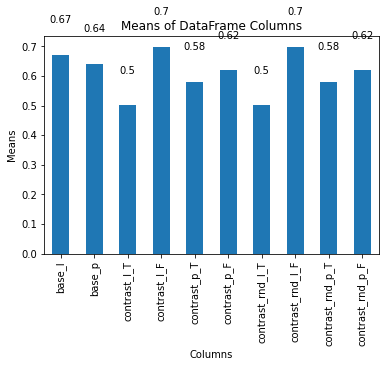

In [8]:
# Calculate means
import pandas as pd
import matplotlib.pyplot as plt

means = dataframe_results_inputx.mean()

# Plot means
ax = means.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Means')
plt.title('Means of DataFrame Columns')

# Annotate bars with values
for i, v in enumerate(means):
    ax.text(i, v + 0.1, str(round(v, 2)), ha='center', va='bottom')

plt.show()

# Data

In [5]:
#@title #**Data:** load in NPI from BLIMP
dataset = 'any' #@param['blimp', 'any']

filename = "prefix+value.tsv" #@param ["npi_present_1", "determiner_noun_agreement_1","prefix+value.tsv"]

if location == 'colab':
  filename = "/content/drive/MyDrive/Thesis_Contrastive/"+ filename

if dataset == 'blimp':
  with jsonlines.open(filename + ".jsonl", 'r') as f:
      dataframe = pd.DataFrame(f)

if dataset == 'any':
  sentences = []
  values = []
  with open("prefix+value.tsv", 'r', encoding='utf-8') as ifh:
      for line in ifh:
          sentence, value = line.strip().split('\t')
          sentences.append(sentence)
          values.append(value)
  print(sentence,value)

We don't want to raise 3.671572208404541


In [6]:
#@title #**Data:** Show data
if dataset == 'any':
  dit = []
  b = False
  for sentence in sentences:
    booleans = get_target(sentence)
    i = 1
    b = False
    for boole in booleans:
      if boole:
        b = True
      if not boole and b:
        i +=1
    dit.append(i)

  lengths = dit

  plt.hist(lengths, bins=20, color='blue', edgecolor='black', align='mid')

  # Adding labels and title
  plt.xlabel('Lengths')
  plt.ylabel('Frequency')
  plt.title('Distribution of Lengths')
  plt.xticks(range(0, 6))

  # Display the plot
  plt.savefig('data_dist', dpi = 800)
  plt.show()

AttributeError: module 'matplotlib' has no attribute 'hist'

# Run Experiments

In [ ]:
LIME TESTS FOR BASE VS CONT FEATURE ATTRIBUTION RAW SCORE COMPARISON.

In [ ]:
#@title #**Loop through 'ANY' NPI and give MRR**
import torch
explanations = ["lime"] #"input_x_gradient", "integrated_gradients", "lime", "deeplift", "gradient_shap","discretized_integrated_gradients"
attributed_fn = "logit" #@param ["logit", "probability", "entropy", "crossentropy", "perplexity", "pcxmi", "kl_divergence", "in_context_pvi", "mc_dropout_prob_avg", "top_p_size"]
# rev = 'False'
normalize = 'True'

base_l= []
contrast_l = []
contrast_rnd_l = []

lime_base_l= []
lime_contrast_l = []
lime_contrast_rnd_l = []

for indexer in ["0","-1","start_ev","'t'"]:

    for explanation in explanations:
      gc.collect()
      model_inseq = inseq.load_model("gpt2", explanation)

      base_l= []
      contrast_l = []
      contrast_rnd_l = []

      i = 0
      for sentence in sentences:
        i += 1

        target = "any"
        foil = "some"
        foil_rnd = "hello"

        baseline = model_inseq.attribute(
            sentence,
            sentence + " " + target,
            attributed_fn=attributed_fn,
        )

        contrast = model_inseq.attribute(
            sentence,
            sentence + " " + foil,
            attributed_fn=attributed_fn,
        )

        contrast_rnd = model_inseq.attribute(
            sentence,
            sentence + " " + foil_rnd,
            attributed_fn=attributed_fn,
        )

        clear_output()
        print(f'{explanation} {i}')

        base_tensor = baseline[0].target_attributions
        contrastive_tensor = contrast[0].target_attributions
        contrastive_rnd_tensor = contrast_rnd[0].target_attributions

        baseline_att = base_tensor.sum(axis = 2)
        contrast_att = contrastive_tensor.sum(axis = 2)
        contrast_rnd_att = contrastive_rnd_tensor.sum(axis = 2)

        baseline_att = torch.flatten(baseline_att[~torch.any(baseline_att.isnan(),dim=1)]).numpy()
        contrast_att = torch.flatten(contrast_att[~torch.any(contrast_att.isnan(),dim=1)]).numpy()
        contrast_rnd_att = torch.flatten(contrast_rnd_att[~torch.any(contrast_rnd_att.isnan(),dim=1)]).numpy()



        targets = get_target(sentence)
        
        if indexer == "-1":
            index = -1
        elif indexer == "0":
            index = 0
        elif indexer == "start_ev":
            index = targets.index(True)
        elif indexer == "'t":
            index = index = get_last_true_index(targets)

        if normalize == 'True':
            baseline_att_normal = normalize_vector(baseline_att)
            contrast_att_normal = normalize_vector(contrast_att)
            contrast_rnd_att_normal = normalize_vector(contrast_rnd_att)    

            base_value = baseline_att_normal[index]
            contrast_value = contrast_att_normal[index]
            contrast_rnd_value = contrast_rnd_att_normal[index]   

        else:
            base_value = baseline_att[index]
            contrast_value = contrast_att[index]
            contrast_rnd_value = contrast_rnd_att[index]

        base_l.append(base_value)
        contrast_l.append(contrast_value)
        contrast_rnd_l.append(contrast_rnd_value)
        
    dataframe_results_inputx = pd.DataFrame(data={'sentences':sentences, 'base':base_l, 'contrast':contrast_l, 'contrast_rnd': contrast_rnd_l})
    dataframe_results_inputx.to_csv(f'input_x_gradient_raws_n_{indexer}.csv', index=False)



lime 951


Attributing with lime...:  80%|████████  | 4/5 [00:00<?, ?it/s]

In [23]:
dataframe_results_inputx = pd.DataFrame(data={'sentences':sentences, 'base':base_l, 'contrast':contrast_l, 'contrast_rnd': contrast_rnd_l})

<AxesSubplot:>

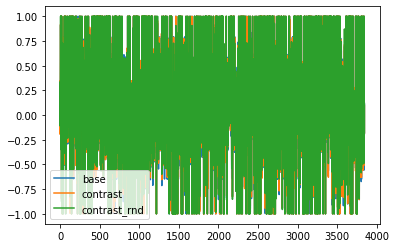

In [24]:
dataframe_results_inputx.plot()

In [25]:
dataframe_results_inputx.to_csv('input_x_gradient_raws_n_start_ev.csv', index=False)

In [11]:
#@title #**Loop through 'ANY' NPI and give MRR**
import torch
explanations = ["lime"] #"input_x_gradient", "integrated_gradients", "lime", "deeplift", "gradient_shap","discretized_integrated_gradients"
attributed_fn = "logit" #@param ["logit", "probability", "entropy", "crossentropy", "perplexity", "pcxmi", "kl_divergence", "in_context_pvi", "mc_dropout_prob_avg", "top_p_size"]
rev = 'False'
Results = {'Method': [], 'class':[], 'MRR': [], 'Dist': []}

full_baselines = {"input_x_gradient":[], "integrated_gradients":[], "lime":[], "deeplift":[], "gradient_shap":[],"discretized_integrated_gradients":[]}
full_contrastive= {"input_x_gradient":[], "integrated_gradients":[], "lime":[], "deeplift":[], "gradient_shap":[],"discretized_integrated_gradients":[]}

full_baselines_org = {"input_x_gradient":[], "integrated_gradients":[], "lime":[], "deeplift":[], "gradient_shap":[],"discretized_integrated_gradients":[]}
full_contrastive_org= {"input_x_gradient":[], "integrated_gradients":[], "lime":[], "deeplift":[], "gradient_shap":[],"discretized_integrated_gradients":[]}



for explanation in explanations:

  gc.collect()
  model_inseq = inseq.load_model("gpt2", explanation)


  baseline_ranks = []
  contrastive_ranks = []
  dist = []
  i = 0
  for sentence in sentences:
    i += 1
    target = "any"
    foil = "some"

    baseline = model_inseq.attribute(
        sentence,
        sentence + " " + target,
        attributed_fn=attributed_fn,
    )

    contrast = model_inseq.attribute(
        sentence,
        sentence + " " + foil,
        attributed_fn=attributed_fn,
    )

    clear_output()
    print(f'{explanation} {i}')
#     sent_len = len(tokenizer(sentence)['input_ids'])

    base_tensor = baseline[0].target_attributions
    contrastive_tensor = contrast[0].target_attributions


    baseline_att = base_tensor.sum(axis = 2)
    contrast_att = contrastive_tensor.sum(axis = 2)
    baseline_att = torch.flatten(baseline_att[~torch.any(baseline_att.isnan(),dim=1)]).numpy()
    contrast_att = torch.flatten(contrast_att[~torch.any(contrast_att.isnan(),dim=1)]).numpy()


#     if filename == 'determiner_noun_agreement_1':
#       targets = [False] * (sent_len - 1)+[True]
#     else:
#       targets = [True] + [False] * (sent_len - 1)

#     baseline_att = baseline_att[:len(targets)]
#     contrast_att = contrast_att[:len(targets)]
    targets = get_target(sentence)

    if rev == 'True':
      contrastive_attributions = contrast_att- baseline_att
    if rev == 'False':
      contrastive_attributions = baseline_att-contrast_att

    rank_baseline = reciprocal_rank(baseline_att, targets)
    rank_contrastive = reciprocal_rank(contrastive_attributions, targets)

    assert len(targets) == len(baseline_att), f'Target/Baseline mismatch \n targets = {targets},\n baseline_att = {baseline_att}'
    assert len(targets) == len(contrastive_attributions), f'Target/Contrast mismatch {targets}, {contrast_att}'
    assert len(contrastive_attributions) == len(baseline_att), f'Baseline/Contrast mismatch {baseline_att}, {contrast_att}'

    baseline_ranks.append(rank_baseline)
    contrastive_ranks.append(rank_contrastive)
    dist.append(len(targets))

  if rev == 'True':
      full_baselines[explanation] = baseline_ranks
      full_contrastive[explanation] = contrastive_ranks
  if rev == 'False':
      full_baselines_org[explanation] = baseline_ranks
      full_contrastive_org[explanation] = contrastive_ranks

  AVG_dist = average(dist)
  MRR_baseline = average(baseline_ranks)
  MRR_contrastive = average(contrastive_ranks)


  Results['Method'].append(explanation)
  Results['Method'].append(explanation)

  Results['class'].append('baseline')
  Results['class'].append('contrastive')

  Results['MRR'].append(MRR_baseline)
  Results['MRR'].append(MRR_contrastive)

  Results['Dist'].append(AVG_dist)
  Results['Dist'].append(AVG_dist)

  print(Results)
dataframe_results = pd.DataFrame(data=Results)

lime 3844
{'Method': ['lime', 'lime'], 'class': ['baseline', 'contrastive'], 'MRR': [0.6243841268127733, 0.5367536169222065], 'Dist': [6.986992715920915, 6.986992715920915]}


In [12]:
with open("limeS_cont.json", 'w') as flie:
  json.dump(full_contrastive_org,flie)
with open("limeS_base.json", 'w') as flie:
  json.dump(full_baselines_org,flie)

In [ ]:
#@title #**Erasure, gradient norm for 'any'**


tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

baseline_ranks_org = []
contrastive_ranks_org = []
dist = []
i = 0

for sentence in sentences:
  input = sentence
  input_tokens = tokenizer(input)['input_ids']
  attention_ids = tokenizer(input)['attention_mask']


  target = "any"
  foil = "some"
  CORRECT_ID = tokenizer(" "+ target)['input_ids']
  FOIL_ID = tokenizer(" "+ foil)['input_ids']

  # Erasure
  base_explanation = erasure_scores(model, input_tokens, attention_ids,correct=CORRECT_ID, normalize=True)
  contra_explanation = erasure_scores(model, input_tokens, attention_ids, correct=CORRECT_ID, foil=FOIL_ID, normalize=True)

  targets = get_target(sentence)

  rank_baseline = reciprocal_rank(base_explanation, targets)
  rank_contrastive = reciprocal_rank(contra_explanation, targets)
  baseline_ranks_org.append(rank_baseline)
  contrastive_ranks_org.append(rank_contrastive)

In [ ]:
#@title #**Erasure, gradient norm for 'blimp'**

baseline_ranks = []
contrastive_ranks_org = []
contrastive_ranks = []
random_ranks = []
kayo = []
kayo_rev = []

dist = []
i = 0


for index, row in dataframe.iterrows():
  print(index)
  clear_output()
  input = row["one_prefix_prefix"]
  target = row["one_prefix_word_good"]
  foil = row["one_prefix_word_bad"]


  # input = sentence
  input_tokens = tokenizer(input)['input_ids']
  attention_ids = tokenizer(input)['attention_mask']

  CORRECT_ID = tokenizer(" "+ target)['input_ids']
  FOIL_ID = tokenizer(" "+ foil)['input_ids']

  # Erasure
  base_explanation       = erasure_scores(model, input_tokens, attention_ids, correct=CORRECT_ID, normalize=True)
  contra_explanation_org = erasure_scores(model, input_tokens, attention_ids, correct=CORRECT_ID, foil=FOIL_ID, normalize=True)
  contra_explanation     = erasure_scores(model, input_tokens, attention_ids, correct=FOIL_ID, foil=CORRECT_ID, normalize=True)
  contra_explanation_kayo_rev = erasure_scores(model, input_tokens, attention_ids, foil=CORRECT_ID, normalize=True)
  contra_explanation_kayo = erasure_scores(model, input_tokens, attention_ids, foil=FOIL_ID, normalize=True)


  sent_len = len(tokenizer(input)['input_ids'])
  targets = [True] + [False] * (sent_len - 1)

  random_expl =  generate_one_hot_list(len(targets))

  rank_baseline = reciprocal_rank(base_explanation, targets)
  rank_contrastive = reciprocal_rank(contra_explanation, targets)
  rank_contrastive_org = reciprocal_rank(contra_explanation_org, targets)
  rank_random = reciprocal_rank(random_expl, targets)
  rank_contra_explanation_kayo_rev = reciprocal_rank(contra_explanation_kayo_rev, targets)
  rank_contra_explanation_kayo= reciprocal_rank(contra_explanation_kayo, targets)


  baseline_ranks.append(rank_baseline)
  contrastive_ranks_org.append(rank_contrastive_org)
  contrastive_ranks.append(rank_contrastive)
  random_ranks.append(rank_random)
  kayo.append(rank_contra_explanation_kayo)
  kayo_rev.append(rank_contra_explanation_kayo_rev)


erasure_dict = {"erasure_base": baseline_ranks, "erasure_contrast_org": contrastive_ranks_org, "erasure_contrast":contrastive_ranks, "random":random_ranks, "erasure_kayo_rev": kayo_rev, "erasure_kayo": kayo }

In [ ]:
if location == 'colab':
  with open('/content/drive/MyDrive/Thesis_Contrastive/full_baselines_org.json', 'r') as ifh:
    full_baselines = json.load(ifh)

  with open('/content/drive/MyDrive/Thesis_Contrastive/full_contrastive_org.json', 'r') as ofh:
      full_contrastive = json.load(ofh)

else:
  with open('full_baselines.json', 'r') as ifh:
      full_baselines = json.load(ifh)

  with open('full_contrastive.json', 'r') as ofh:
      full_contrastive = json.load(ofh)


In [ ]:
 with open('/content/drive/MyDrive/Thesis_Contrastive/random.json', 'r') as ifh:
    random = json.load(ifh)

In [ ]:
random = {'random': random}
random_frame = pd.DataFrame.from_dict(random)

In [ ]:
random_frame

In [ ]:
# del full_baselines['discretized_integrated_gradients']
# del full_contrastive['discretized_integrated_gradients']

key_mapping_base = {'input_x_gradient': 'input_x_gradient_base_org', 'integrated_gradients': 'integrated_gradients_base_org', 'lime': 'lime_base_org', 'deeplift': 'deeplift_base_org', 'gradient_shap': 'gradient_shap_base_org'}
full_baselines = {key_mapping_base.get(old_key, old_key): value for old_key, value in full_baselines.items()}

key_mapping_cont = {'input_x_gradient': 'input_x_gradient_contrast_org', 'integrated_gradients': 'integrated_gradients_contrast_org', 'lime': 'lime_contrast_org', 'deeplift': 'deeplift_contrast_org', 'gradient_shap': 'gradient_shap_contrast_org'}
full_contrastive = {key_mapping_cont.get(old_key, old_key): value for old_key, value in full_contrastive.items()}

baseline_frame_org = pd.DataFrame.from_dict(full_baselines)
contrastive_frame_org = pd.DataFrame.from_dict(full_contrastive)

# Concatenate DataFrames
merged_df = pd.concat([baseline_frame, contrastive_frame])

# Display the merged DataFrame

In [ ]:
erasure_frame = pd.DataFrame.from_dict(erasure_dict)

In [ ]:
erasure_frame.to_csv('Results_erasure.csv', index=False)

In [ ]:
base = erasure_frame['erasure_base'].mean()
contrast = erasure_frame['erasure_contrast'].mean()
contrast_org = erasure_frame['erasure_contrast_org'].mean()
kayoyin = erasure_frame['erasure_kayo'].mean()
kayoyin_rev = erasure_frame['erasure_kayo_rev'].mean()

randomzz = erasure_frame['random'].mean()

print(base, contrast, contrast_org, randomzz,kayoyin,kayoyin_rev)

0.9395333333333333 0.7950166666666667 0.7388666666666667 0.6715 0.8833333333333333 0.8985833333333333


In [ ]:
merged_df = pd.concat([ random_frame,baseline_frame, contrastive_frame, baseline_frame_org,contrastive_frame_org ], axis=1)

In [ ]:
merged_df

,random,input_x_gradient_base,integrated_gradients_base,lime_base,deeplift_base,gradient_shap_base,input_x_gradient_contrast,integrated_gradients_contrast,lime_contrast,deeplift_contrast,...,input_x_gradient_base_org,integrated_gradients_base_org,lime_base_org,deeplift_base_org,gradient_shap_base_org,input_x_gradient_contrast_org,integrated_gradients_contrast_org,lime_contrast_org,deeplift_contrast_org,gradient_shap_contrast_org
0,0.333333,0.250000,0.333333,0.333333,0.500000,1.000000,0.333333,1.000000,0.5,0.250000,...,0.250000,0.333333,0.200000,0.500000,0.250000,0.333333,0.200000,0.250000,1.000000,0.200000
1,0.200000,0.200000,0.500000,0.333333,0.333333,0.500000,0.250000,0.500000,1.0,0.200000,...,0.200000,0.500000,0.333333,0.333333,0.500000,0.500000,0.500000,0.166667,1.000000,0.500000
2,0.071429,0.500000,0.500000,0.111111,0.500000,0.500000,0.250000,0.071429,1.0,1.000000,...,0.500000,0.500000,0.071429,0.500000,0.333333,0.083333,0.500000,0.066667,0.090909,0.500000
3,1.000000,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000,1.000000,1.0,0.500000,...,0.500000,0.500000,0.333333,0.500000,1.000000,0.500000,0.333333,0.500000,0.500000,0.500000
4,0.052632,0.083333,0.333333,0.083333,0.125000,0.166667,0.058824,0.500000,1.0,0.066667,...,0.083333,0.333333,0.142857,0.125000,0.333333,1.000000,0.166667,0.066667,1.000000,0.058824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3839,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000,0.5,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.500000,0.500000,0.500000,1.000000,0.500000,1.000000
3840,0.250000,0.333333,0.500000,1.000000,0.333333,0.333333,1.000000,0.250000,1.0,0.500000,...,0.333333,0.500000,1.000000,0.333333,0.500000,0.333333,1.000000,0.250000,0.250000,0.500000
3841,0.052632,0.111111,0.500000,1.000000,0.333333,0.500000,0.142857,0.066667,1.0,0.062500,...,0.111111,0.500000,1.000000,0.333333,0.500000,0.125000,0.500000,0.058824,0.333333,0.500000
3842,0.052632,0.090909,1.000000,0.333333,0.125000,0.125000,0.250000,0.055556,1.0,0.166667,...,0.090909,1.000000,0.500000,0.125000,0.076923,0.250000,0.500000,0.050000,0.250000,0.052632


In [ ]:
merged_df.to_csv('Results.csv', index=False)

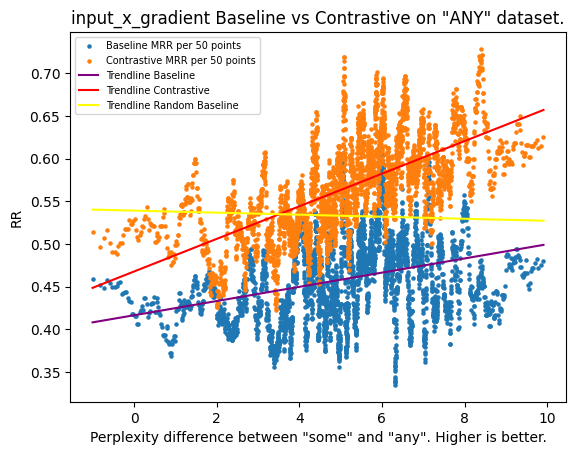

In [ ]:
# Zip and sort based on x_values
import json
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

rev = 'True' #@param['True', 'False']

if rev == 'True':
  with open("/content/drive/MyDrive/Thesis_Contrastive/full_contrastive.json", 'r') as flie:
    contrastive = json.load(flie)
  with open("/content/drive/MyDrive/Thesis_Contrastive/full_baselines.json", 'r') as flie:
    baselines = json.load(flie)
if rev == 'False':
  with open("/content/drive/MyDrive/Thesis_Contrastive/full_contrastive_org.json", 'r') as flie:
    contrastive = json.load(flie)
  with open("/content/drive/MyDrive/Thesis_Contrastive/full_baselines_org.json", 'r') as flie:
    baselines = json.load(flie)

with open("/content/drive/MyDrive/Thesis_Contrastive/random.json", 'r') as flie:
  random_ranks = json.load(flie)

sentences = []
values = []
with open("/content/drive/MyDrive/Thesis_Contrastive/prefix+value.tsv", 'r', encoding='utf-8') as ifh:
    for line in ifh:
        sentence, value = line.strip().split('\t')
        sentences.append(sentence)
        values.append(value)
print(sentence,value)


method = 'input_x_gradient' #@param ['input_x_gradient','integrated_gradients' ,'deeplift' , 'lime', 'gradient_shap', 'erasure']

values = [float(x) for x in values]
sorted_data = sorted(zip(values, random_ranks, baselines[method], contrastive[method]), key=lambda x: x[0])
x_sorted, random_baselines,y1_sorted, y2_sorted = zip(*sorted_data)


# Plotting with smaller dots
window_size = 50
y1_averages = np.convolve(y1_sorted, np.ones(window_size)/window_size, mode='valid')
y2_averages = np.convolve(y2_sorted, np.ones(window_size)/window_size, mode='valid')
y3_averages = np.convolve(random_baselines, np.ones(window_size)/window_size, mode='valid')
x_averages = np.convolve(x_sorted, np.ones(window_size)/window_size, mode='valid')

# Fit polynomial trendlines
degree = 1  # You can adjust the degree of the polynomial
z1 = np.polyfit(x_averages, y1_averages, degree)
z2 = np.polyfit(x_averages, y2_averages, degree)
z3 = np.polyfit(x_averages, y3_averages, degree)

# Create polynomial functions
p1 = np.poly1d(z1)
p2 = np.poly1d(z2)
p3 = np.poly1d(z3)


# Plotting
plt.scatter(x_averages[:len(y1_averages)], y1_averages, label='Baseline MRR per 50 points', s=5)
plt.scatter(x_averages[:len(y2_averages)], y2_averages, label='Contrastive MRR per 50 points', s=5)


# Plot trendlines
plt.plot(x_averages, p1(x_averages), label='Trendline Baseline', color='purple')
plt.plot(x_averages, p2(x_averages), label='Trendline Contrastive', color='red')
plt.plot(x_averages, p3(x_averages), label='Trendline Random Baseline', color='yellow')

# Adding labels and legend
plt.xlabel('Perplexity difference between "some" and "any". Higher is better.')
plt.ylabel('RR')
plt.legend(fontsize = 7)
plt.title(f'{method} Baseline vs Contrastive on "ANY" dataset.')
# Set a higher resolution (dpi) for the plot
plt.savefig('scatter_plot_averages.png', dpi=400)  # Adjust the filename and dpi as needed
plt.show()

In [ ]:
#Random Baseline

#@title #**Loop through blimp NPI and give MRR**
import torch
explanation = 'random'
attributed_fn = "logit" #@param ["logit", "probability", "entropy", "crossentropy", "perplexity", "pcxmi", "kl_divergence", "in_context_pvi", "mc_dropout_prob_avg", "top_p_size"]
rev = 'True'
Results = {'Method': [], 'class':[], 'MRR': [], 'Dist': []}
random_ranks = []
for sentence in sentences:

  targets = get_target(sentence)
  baseline_att =  generate_one_hot_list(len(targets))

  rank_random = reciprocal_rank(baseline_att, targets)

  random_ranks.append(rank_random)


MRR_baseline = average(random_ranks)


print(MRR_baseline)

0.5338012703278967


In [ ]:
with open("/content/drive/MyDrive/Thesis_Contrastive/random.json", 'w') as flie:
  json.dump(random_ranks,flie)

In [ ]:
#LIME ONLY

import torch
explanations = ["lime"] #"input_x_gradient", "integrated_gradients", "lime", "deeplift", "gradient_shap","discretized_integrated_gradients"
attributed_fn = "logit" #@param ["logit", "probability", "entropy", "crossentropy", "perplexity", "pcxmi", "kl_divergence", "in_context_pvi", "mc_dropout_prob_avg", "top_p_size"]
rev = 'True'
Results = {'Method': [], 'class':[], 'MRR': [], 'Dist': []}
full_baselines = {"input_x_gradient":[], "integrated_gradients":[], "lime":[], "deeplift":[], "gradient_shap":[],"discretized_integrated_gradients":[]}
full_contrastive= {"input_x_gradient":[], "integrated_gradients":[], "lime":[], "deeplift":[], "gradient_shap":[],"discretized_integrated_gradients":[]}
for explanation in explanations:

  gc.collect()
  model_inseq = inseq.load_model("gpt2", explanation)


  baseline_ranks = []
  contrastive_ranks = []
  dist = []
  i = 0
  for sentence in sentences:
    i += 1
    target = "any"
    foil = "some"

    baseline = model_inseq.attribute(
        sentence,
        sentence + " " + target,
        attributed_fn=attributed_fn,
    )

    contrast = model_inseq.attribute(
        sentence,
        sentence + " " + foil,
        attributed_fn='contrast_logits_diff',
        contrast_targets=sentence + " "+target,
    )

    clear_output()
    print(f'{explanation} {i}')
#     sent_len = len(tokenizer(sentence)['input_ids'])

    base_tensor = baseline[0].target_attributions
    contrastive_tensor = contrast[0].target_attributions


    baseline_att = base_tensor.sum(axis = 2)
    contrast_att = contrastive_tensor.sum(axis = 2)
    baseline_att = torch.flatten(baseline_att[~torch.any(baseline_att.isnan(),dim=1)]).numpy()
    contrast_att = torch.flatten(contrast_att[~torch.any(contrast_att.isnan(),dim=1)]).numpy()


#     if filename == 'determiner_noun_agreement_1':
#       targets = [False] * (sent_len - 1)+[True]
#     else:
#       targets = [True] + [False] * (sent_len - 1)

#     baseline_att = baseline_att[:len(targets)]
#     contrast_att = contrast_att[:len(targets)]
    targets = get_target(sentence)

    rank_baseline = reciprocal_rank(baseline_att, targets)
    rank_contrastive = reciprocal_rank(contrast_att, targets)


    baseline_ranks.append(rank_baseline)
    contrastive_ranks.append(rank_contrastive)
    dist.append(len(targets))


  full_baselines[explanation] = baseline_ranks
  full_contrastive[explanation] = contrastive_ranks

  AVG_dist = average(dist)
  MRR_baseline = average(baseline_ranks)
  MRR_contrastive = average(contrastive_ranks)


  Results['Method'].append(explanation)
  Results['Method'].append(explanation)

  Results['class'].append('baseline')
  Results['class'].append('contrastive')

  Results['MRR'].append(MRR_baseline)
  Results['MRR'].append(MRR_contrastive)

  Results['Dist'].append(AVG_dist)
  Results['Dist'].append(AVG_dist)

  print(Results)
dataframe_results = pd.DataFrame(data=Results)

In [ ]:
full_baselines['lime']

# Results

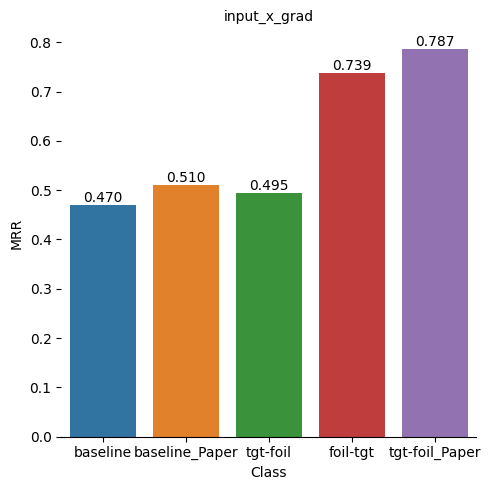

In [ ]:
#@title #**Results:** npi_present_1 reversal results.
results_npi_1 = {'Method': ['input_x_grad','input_x_grad', 'input_x_grad','input_x_grad', 'input_x_grad'],'class': ['baseline','baseline_Paper','tgt-foil','foil-tgt','tgt-foil_Paper'], 'MRR':[0.4699,0.510,0.4948,0.738683333,0.787]}
df_res = pd.DataFrame(data=results_npi_1)
# Assuming 'class' is the column containing class information
g = sns.catplot(kind='bar', data=df_res, x='class', y='MRR', col='Method', hue='class')
# Customize the plot as needed
g.set_axis_labels('Class', 'MRR')
g.set_titles(col_template='{col_name}')
g.despine(left=True)

# Add values on top of the bars
for ax in g.axes.flat:
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.3f}', ha='center', va='bottom')

# Show the plot
plt.show()

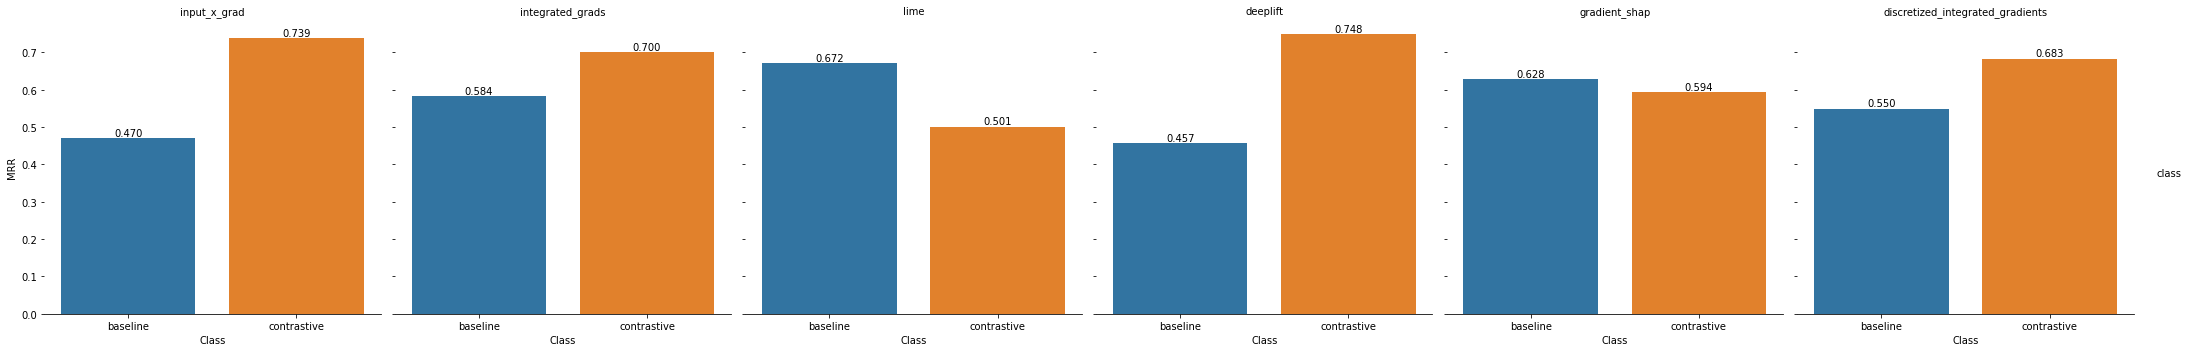

In [ ]:
#@title #**Results:** npi_present_1 results.

results_npi_1 = {'Method': ['input_x_grad', 'integrated_grads', 'lime', 'deeplift', 'gradient_shap', 'discretized_integrated_gradients','input_x_grad', 'integrated_grads', 'lime', 'deeplift', 'gradient_shap', 'discretized_integrated_gradients'],'class': ['baseline','baseline','baseline','baseline','baseline','baseline', 'contrastive','contrastive','contrastive','contrastive','contrastive','contrastive'], 'MRR':[0.4699,0.5841333333, 0.6716833333,0.45684999999 ,0.6275928, 0.54976666666 ,0.738683333,0.69993571, 0.5014499999999973,0.748433333,0.5938833,  0.6834761904]}
df_res = pd.DataFrame(data=results_npi_1)
# Assuming 'class' is the column containing class information
g = sns.catplot(kind='bar', data=df_res, x='class', y='MRR', col='Method', hue='class')

# Customize the plot as needed
g.set_axis_labels('Class', 'MRR')
g.set_titles(col_template='{col_name}')
g.despine(left=True)

# Add values on top of the bars
for ax in g.axes.flat:
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.3f}', ha='center', va='bottom')

# Show the plot
plt.show()

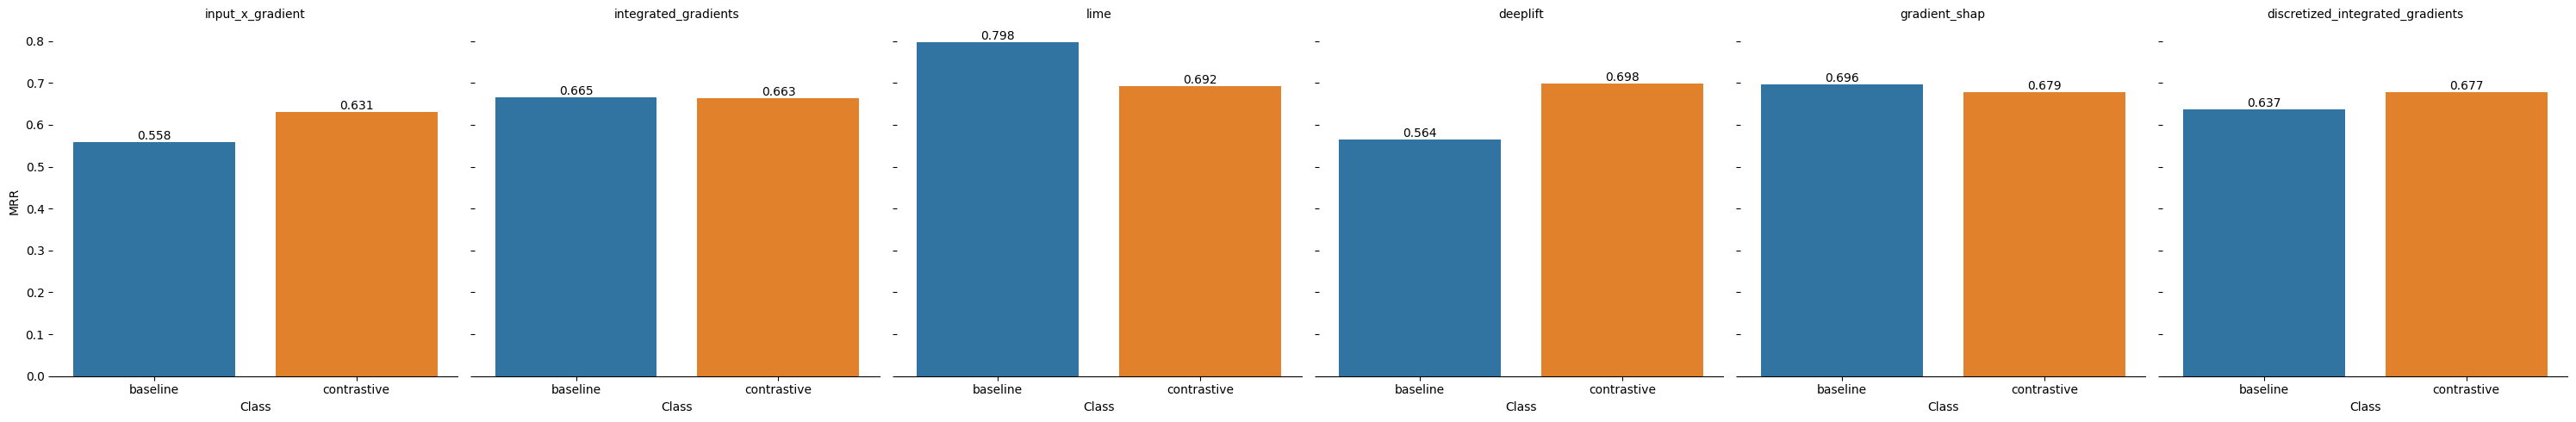

In [ ]:
#@title #**Results:** npi_present_2 results.

results_npi_2 = {'Method': ['input_x_gradient', 'input_x_gradient', 'integrated_gradients', 'integrated_gradients', 'lime', 'lime', 'deeplift', 'deeplift', 'gradient_shap', 'gradient_shap', 'discretized_integrated_gradients', 'discretized_integrated_gradients'], 'class': ['baseline', 'contrastive', 'baseline', 'contrastive', 'baseline', 'contrastive', 'baseline', 'contrastive', 'baseline', 'contrastive', 'baseline', 'contrastive'], 'MRR': [0.5579499999999994, 0.6310166666666669, 0.6647666666666667, 0.6632000000000005, 0.7978833333333338, 0.6919000000000005, 0.5639999999999991, 0.6976000000000007, 0.6956000000000004, 0.678716666666667,0.6370833333333334, 0.6774000000000001]}
df_res = pd.DataFrame(data=results_npi_2)
# Assuming 'class' is the column containing class information
g = sns.catplot(kind='bar', data=df_res, x='class', y='MRR', col='Method', hue='class')

# Customize the plot as needed
g.set_axis_labels('Class', 'MRR')
g.set_titles(col_template='{col_name}')
g.despine(left=True)

# Add values on top of the bars
for ax in g.axes.flat:
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.3f}', ha='center', va='bottom')
# Show the plot
plt.show()

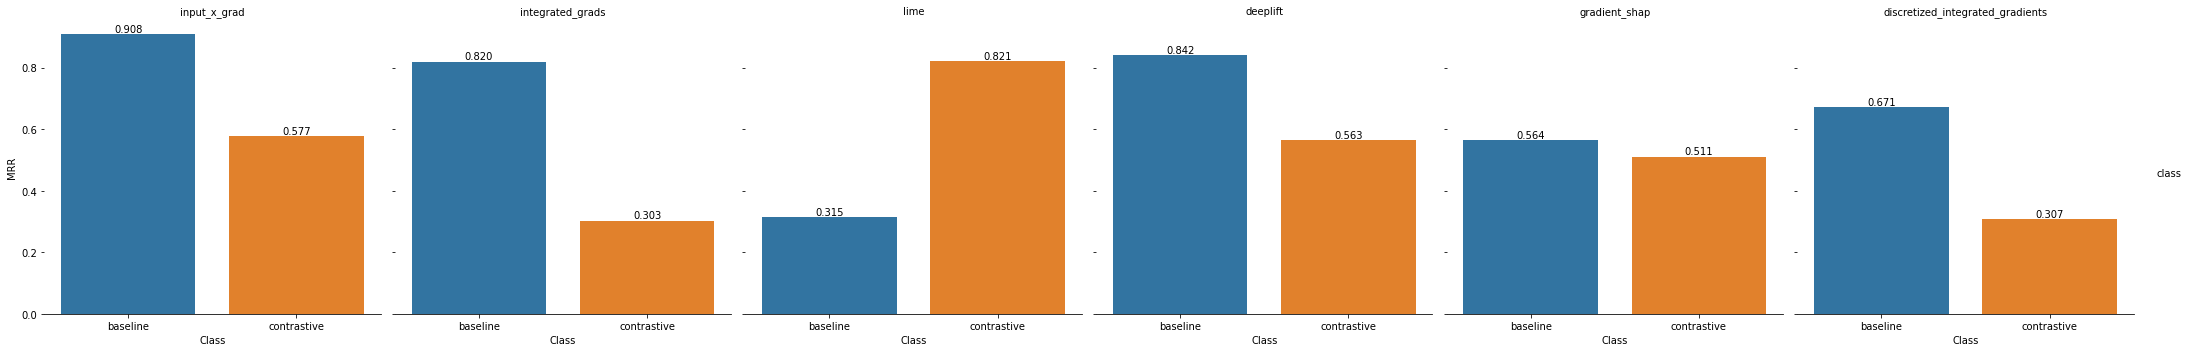

In [ ]:
#@title #**Results:** determiner_noun_agreement_1 results.
import seaborn as sns
import matplotlib.pyplot as plt
results_determiner_noun = {'Method': ['input_x_grad', 'integrated_grads', 'lime', 'deeplift', 'gradient_shap', 'input_x_grad', 'integrated_grads', 'lime', 'deeplift', 'gradient_shap', 'discretized_integrated_gradients', 'discretized_integrated_gradients'],'class': ['baseline','baseline','baseline','baseline','baseline', 'contrastive','contrastive','contrastive','contrastive','contrastive', 'baseline', 'contrastive'], 'MRR':[0.9082428571428581,0.8196607142857156,0.31504126984126846,0.8419928571428584,0.5638011904761897,0.5770000000000003,0.30320277777777643,0.8205642857142863,0.5633964285714284,0.5110353174603166,0.6711214285714291,0.3070515873015864]}
df_res = pd.DataFrame(data=results_determiner_noun)
# Assuming 'class' is the column containing class information
g = sns.catplot(kind='bar', data=df_res, x='class', y='MRR', col='Method', hue='class')

# Customize the plot as needed
g.set_axis_labels('Class', 'MRR')
g.set_titles(col_template='{col_name}')
g.despine(left=True)

# Add values on top of the bars
for ax in g.axes.flat:
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.3f}', ha='center', va='bottom')
# Show the plot
plt.show()

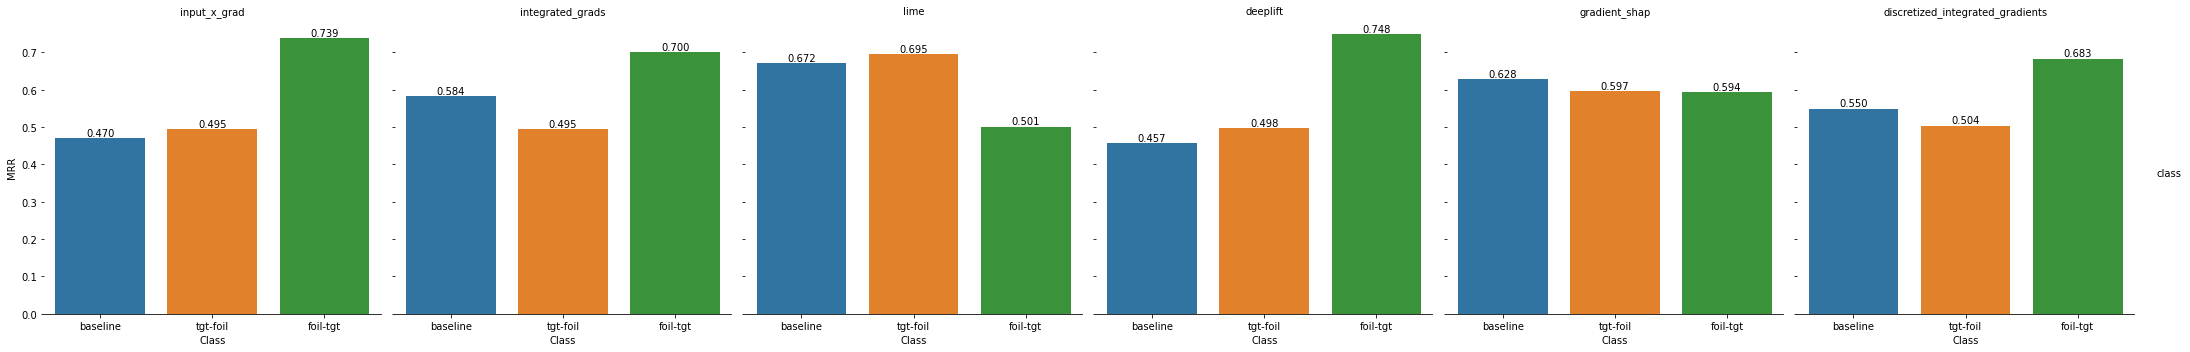

In [ ]:
#@title #**Results:** determiner_noun_agreement_1 results.
import seaborn as sns
import matplotlib.pyplot as plt
results_npi_1 = {'Method': ['input_x_grad', 'integrated_grads', 'lime', 'deeplift', 'gradient_shap', 'discretized_integrated_gradients','input_x_grad', 'integrated_grads', 'lime', 'deeplift', 'gradient_shap', 'discretized_integrated_gradients','input_x_grad', 'integrated_grads', 'lime', 'deeplift', 'gradient_shap', 'discretized_integrated_gradients'],'class': ['baseline','baseline','baseline','baseline','baseline','baseline','tgt-foil','tgt-foil','tgt-foil','tgt-foil','tgt-foil','tgt-foil', 'foil-tgt','foil-tgt','foil-tgt','foil-tgt','foil-tgt','foil-tgt'], 'MRR':[0.4699,0.5841333333, 0.6716833333,0.45684999999 ,0.6275928, 0.54976666666 ,0.4948, 0.49498333,0.6947166666666674,0.498061904, 0.597342857,0.50434999,0.738683333,0.69993571, 0.5014499999999973,0.748433333,0.5938833,  0.6834761904]}
df_res = pd.DataFrame(data=results_npi_1)
# Assuming 'class' is the column containing class information
g = sns.catplot(kind='bar', data=df_res, x='class', y='MRR', col='Method', hue='class')

# Customize the plot as needed
g.set_axis_labels('Class', 'MRR')
g.set_titles(col_template='{col_name}')
g.despine(left=True)

# Add values on top of the bars
for ax in g.axes.flat:
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.3f}', ha='center', va='bottom')
# Show the plot
plt.show()

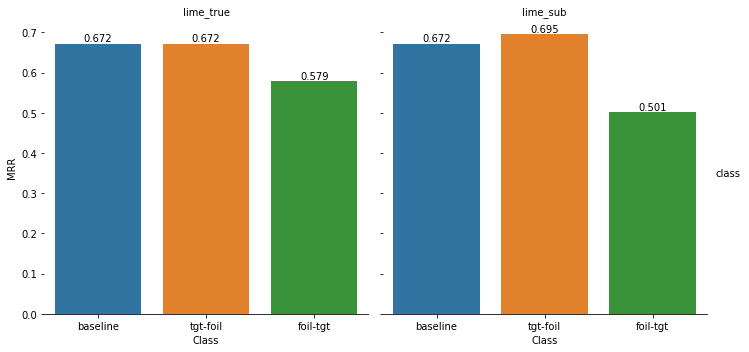

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
results_npi_1 = {'Method': ['lime_true', 'lime_sub', 'lime_true','lime_sub', 'lime_true','lime_sub'],'class': ['baseline','baseline','tgt-foil','tgt-foil', 'foil-tgt','foil-tgt'], 'MRR':[0.672,0.672,0.672,0.695,0.579,0.501]}
df_res = pd.DataFrame(data=results_npi_1)
# Assuming 'class' is the column containing class information
g = sns.catplot(kind='bar', data=df_res, x='class', y='MRR', col='Method', hue='class')

# Customize the plot as needed
g.set_axis_labels('Class', 'MRR')
g.set_titles(col_template='{col_name}')
g.despine(left=True)

# Add values on top of the bars
for ax in g.axes.flat:
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.3f}', ha='center', va='bottom')
# Show the plot
plt.show()

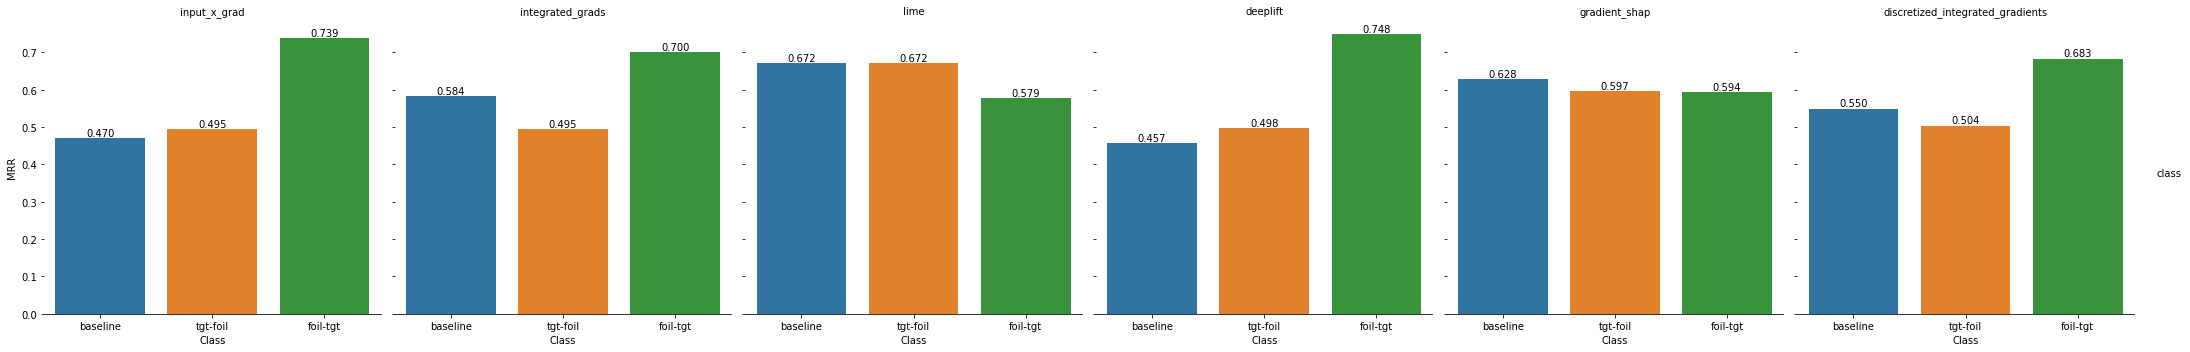

In [ ]:
#@title #**Results:** determiner_noun_agreement_1 results.
import seaborn as sns
import matplotlib.pyplot as plt
results_npi_1 = {'Method': ['input_x_grad', 'integrated_grads', 'lime', 'deeplift', 'gradient_shap', 'discretized_integrated_gradients','input_x_grad', 'integrated_grads', 'lime', 'deeplift', 'gradient_shap', 'discretized_integrated_gradients','input_x_grad', 'integrated_grads', 'lime', 'deeplift', 'gradient_shap', 'discretized_integrated_gradients'],'class': ['baseline','baseline','baseline','baseline','baseline','baseline','tgt-foil','tgt-foil','tgt-foil','tgt-foil','tgt-foil','tgt-foil', 'foil-tgt','foil-tgt','foil-tgt','foil-tgt','foil-tgt','foil-tgt'], 'MRR':[0.4699,0.5841333333, 0.6716833333,0.45684999999 ,0.6275928, 0.54976666666 ,0.4948, 0.49498333,0.67236904,0.498061904, 0.597342857,0.50434999,0.738683333,0.69993571, 0.5787190476,0.748433333,0.5938833,  0.6834761904]}
df_res = pd.DataFrame(data=results_npi_1)
# Assuming 'class' is the column containing class information
g = sns.catplot(kind='bar', data=df_res, x='class', y='MRR', col='Method', hue='class')

# Customize the plot as needed
g.set_axis_labels('Class', 'MRR')
g.set_titles(col_template='{col_name}')
g.despine(left=True)

# Add values on top of the bars
for ax in g.axes.flat:
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.3f}', ha='center', va='bottom')
# Show the plot
plt.show()

# Old Code from here down

In [ ]:
#@title #**Loop through blimp NPI and give MRR**
import torch
explanation = "deeplift" #@param ["input_x_gradient", "integrated_gradients", "occlusion", "lime", "deeplift", "gradient_shap", "discretized_integrated_gradients"]
aggregator = "sum" #@param ["sum", "mean", "vnorm", "max", "min", "prod", "absmax", "default"]
attributed_fn = "logit" #@param ["logit", "probability", "entropy", "crossentropy", "perplexity", "pcxmi", "kl_divergence", "in_context_pvi", "mc_dropout_prob_avg", "top_p_size"]
rev = "False" #@param ['True', 'False']
gc.collect()
model_inseq = inseq.load_model("gpt2", explanation)

baseline_ranks = []
contrastive_ranks = []
dist = []

for index, row in dataframe.iterrows():
  sentence = row["one_prefix_prefix"]
  target = row["one_prefix_word_good"]
  foil = row["one_prefix_word_bad"]


  # encoded_target = tokenizer(' '+ target)['input_ids'][0]
  # target = tokenizer.decode(encoded_target)

  # encoded_foil = tokenizer(' '+ foil)['input_ids'][0]
  # foil = tokenizer.decode(encoded_foil)


  baseline = model_inseq.attribute(
      sentence,
      sentence + " " + target,
      attributed_fn=attributed_fn,
  )


  contrast = model_inseq.attribute(
      sentence,
      sentence + " " + foil,
      attributed_fn=attributed_fn,
  )

  clear_output()
  print(f'target = {target}, foil = {foil}, sentence = {sentence}')
  sent_len = len(tokenizer(sentence)['input_ids'])


  base_tensor = baseline[0].target_attributions
  contrastive_tensor = contrast[0].target_attributions

  print(base_tensor.size())
  print(contrastive_tensor.size())


  # contrastive_feature = base_tensor-contrastive_tensor
  # contrastive = copy.deepcopy(baseline)
  # contrastive[0].target_attributions = contrastive_feature
  baseline_att = base_tensor.sum(axis = 2)
  contrast_att = contrastive_tensor.sum(axis = 2)
  baseline_att = torch.flatten(baseline_att[~torch.any(baseline_att.isnan(),dim=1)]).numpy()
  contrast_att = torch.flatten(contrast_att[~torch.any(contrast_att.isnan(),dim=1)]).numpy()


  if filename == 'determiner_noun_agreement_1':
    targets = [False] * (sent_len - 1)+[True]
  else:
    targets = [True] + [False] * (sent_len - 1)
  baseline_att = baseline_att[:len(targets)]
  contrast_att = contrast_att[:len(targets)]

  if rev == 'True':
    contrastive_attributions = contrast_att- baseline_att
  if rev == 'False':
    contrastive_attributions = baseline_att-contrast_att

  rank_baseline = reciprocal_rank(baseline_att, targets)
  rank_contrastive = reciprocal_rank(contrastive_attributions, targets)

  assert len(targets) == len(baseline_att), f'Target/Baseline mismatch \n targets = {targets},\n baseline_att = {baseline_att}'
  assert len(targets) == len(contrastive_attributions), f'Target/Contrast mismatch {targets}, {contrast_att}'
  assert len(contrastive_attributions) == len(baseline_att), f'Baseline/Contrast mismatch {baseline_att}, {contrast_att}'

  baseline_ranks.append(rank_baseline)
  contrastive_ranks.append(rank_contrastive)
  dist.append(sent_len)


AVG_dist = average(dist)
MRR_baseline = average(baseline_ranks)
MRR_contrastive = average(contrastive_ranks)

print(f'Average Distance is   {AVG_dist}')
print(f'Baseline MRR is       {MRR_baseline}')
print(f'Contrastive MRR is    {MRR_contrastive}')

image.png

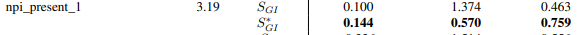

npi_present_1:

Average Distance is   3.15

Baseline MRR is       0.470

Contrastive MRR is    0.495


---



npi_present_2:

Average Distance is   2.489

Baseline MRR is       0.558

Contrastive MRR is    0.769


---

............image.png

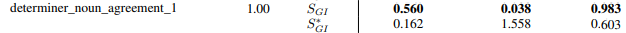

determiner_noun_agreement_1

Average Distance is   1 (always)

Baseline MRR is       0.908

Contrastive MRR is    0.394


---



npi_present_1: REVERSED

Average Distance is   3.15

Baseline MRR is       0.470

Contrastive MRR is    0.739


---

determiner_noun_agreement_1: REVERSED

Average Distance is   1 (always)

Baseline MRR is       0.908

Contrastive MRR is    0.577


In [ ]:
#@title #**Plots** ?

# Data for MRR-baseline
labels_baseline = ['npi-1', 'npi-1*','npi-1-rev', 'det', 'det*',  'det-rev']
MRR_baseline = [0.470, 0.463, 0.470,0.908, 0.983,  0.908]

# Data for MRR-contrastive
labels_contrastive = ['npi-1', 'npi-1*','npi-1-rev', 'det', 'det*',  'det-rev']
MRR_contrastive = [0.495, 0.759, 0.739, 0.394, 0.603, 0.577]

# Color palette
colors = sns.color_palette('Dark2')

# Plotting MRR-baseline and MRR-contrastive horizontally
fig, (ax_baseline, ax_contrastive) = plt.subplots(1, 2, figsize=(16, 6))

# Bar width
bar_width = 0.4
bar_positions = np.arange(len(labels_baseline))

# Bar plots for MRR-baseline
ax_baseline.bar(bar_positions, MRR_baseline, color=colors[0], width=bar_width, edgecolor='grey', label='MRR-baseline')

# Adding labels and legend for MRR-baseline
ax_baseline.set_xlabel('Labels', fontweight='bold', fontsize=15)
ax_baseline.set_xticks(bar_positions)
ax_baseline.set_xticklabels(labels_baseline)
ax_baseline.legend()

# Bar plots for MRR-contrastive
ax_contrastive.bar(bar_positions, MRR_contrastive, color=colors[1], width=bar_width, edgecolor='grey', label='MRR-contrastive')

# Adding labels and legend for MRR-contrastive
ax_contrastive.set_xlabel('Labels', fontweight='bold', fontsize=15)
ax_contrastive.set_xticks(bar_positions)
ax_contrastive.set_xticklabels(labels_contrastive)
ax_contrastive.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plots horizontally
plt.show()


In [ ]:
#@title #**Inseq:** explanations with paper hyperparams
sentence = "Can you stop the dog from" #@param {type:"string"}
target = "barking" #@param {type:"string"}
foil = "walking" #@param {type:"string"}
explanation = "input_x_gradient" #@param ["input_x_gradient", "integrated_gradients", "occlusion", "lime", "deeplift", "gradient_shap", "discretized_integrated_gradients"]
aggregator = "sum" #@param ["sum", "mean", "vnorm", "max", "min", "prod", "absmax", "default"]
attributed_fn = "logit" #@param ["logit", "probability", "entropy", "crossentropy", "perplexity", "pcxmi", "kl_divergence", "in_context_pvi", "mc_dropout_prob_avg", "top_p_size"]
contrast_attributed_fn = "contrast_logits_diff" #@param ["contrast_logits", "contrast_prob", "contrast_logits_diff", "contrast_prob_diff"]


torch.cuda.empty_cache()
gc.collect()
model_inseq = inseq.load_model("gpt2", explanation)


baseline = model_inseq.attribute(
    sentence,
    sentence + " " + target,
    internal_batch_size=50,
    attributed_fn=attributed_fn,
    n_steps=500
)


contrast = model_inseq.attribute(
    sentence,
    sentence + " " + foil,
    internal_batch_size=50,
    attributed_fn=attributed_fn,
    n_steps=500
)


contrastive_feature = baseline[0].target_attributions - contrast[0].target_attributions
contrastive = copy.deepcopy(baseline)
contrastive[0].target_attributions = contrastive_feature


if explanation in ["input_x_gradient","occlusion", "lime", "discretized_integrated_gradients"]:
  out = model_inseq.attribute(
      sentence,
      sentence + " " + target,
      attributed_fn= contrast_attributed_fn,
      contrast_targets= sentence + " " + foil,
      # We also visualize the corresponding step score
      step_scores=[contrast_attributed_fn]
  )


clear_output()


print("Baseline saliency with forced target")
baseline.show(aggregator = aggregator)
print("Baseline saliency with forced foil")
contrast.show(aggregator = aggregator)
print("Contrastive saliency by subtracting feature matrices")
contrastive.show(aggregator = aggregator)
if explanation in ["input_x_gradient","occlusion", "lime", "discretized_integrated_gradients"]:
  print("Contrastive saliency by inseq library")
  out.show(aggregator = aggregator)

In [ ]:
#@title #**Loop through blimp NPI and give MRR** Use for disc_int_grads
#@markdown I hate colab so much pls kill me.
import torch
explanations = ["input_x_gradient", "integrated_gradients", "lime", "deeplift", "gradient_shap"] #"discretized_integrated_gradients"
attributed_fn = "logit" #@param ["logit", "probability", "entropy", "crossentropy", "perplexity", "pcxmi", "kl_divergence", "in_context_pvi", "mc_dropout_prob_avg", "top_p_size"]
revs = ['True', 'False']
Results = []


for explanation in explanations:

  gc.collect()
  model_inseq = inseq.load_model("gpt2", explanation)

  for rev in revs:

    baseline_ranks = []
    contrastive_ranks = []
    dist = []

    for index, row in dataframe.iterrows():
      sentence = row["one_prefix_prefix"]
      target = row["one_prefix_word_good"]
      foil = row["one_prefix_word_bad"]

      baseline = model_inseq.attribute(
          sentence,
          sentence + " " + target,
          attributed_fn=attributed_fn,
      )

      contrast = model_inseq.attribute(
          sentence,
          sentence + " " + foil,
          attributed_fn=attributed_fn,
      )

      clear_output()
      print(f'target = {target}, foil = {foil}, sentence = {sentence}')
      sent_len = len(tokenizer(sentence)['input_ids'])


      base_tensor = baseline[0].target_attributions
      contrastive_tensor = contrast[0].target_attributions

      print(base_tensor.size())
      print(contrastive_tensor.size())


      baseline_att = base_tensor.sum(axis = 2)
      contrast_att = contrastive_tensor.sum(axis = 2)
      baseline_att = torch.flatten(baseline_att[~torch.any(baseline_att.isnan(),dim=1)]).numpy()
      contrast_att = torch.flatten(contrast_att[~torch.any(contrast_att.isnan(),dim=1)]).numpy()


      if filename == 'determiner_noun_agreement_1':
        targets = [False] * (sent_len - 1)+[True]
      else:
        targets = [True] + [False] * (sent_len - 1)

      baseline_att = baseline_att[:len(targets)]
      contrast_att = contrast_att[:len(targets)]

      if rev == 'True':
        contrastive_attributions = contrast_att- baseline_att
      if rev == 'False':
        contrastive_attributions = baseline_att-contrast_att

      rank_baseline = reciprocal_rank(baseline_att, targets)
      rank_contrastive = reciprocal_rank(contrastive_attributions, targets)

      assert len(targets) == len(baseline_att), f'Target/Baseline mismatch \n targets = {targets},\n baseline_att = {baseline_att}'
      assert len(targets) == len(contrastive_attributions), f'Target/Contrast mismatch {targets}, {contrast_att}'
      assert len(contrastive_attributions) == len(baseline_att), f'Baseline/Contrast mismatch {baseline_att}, {contrast_att}'

      baseline_ranks.append(rank_baseline)
      contrastive_ranks.append(rank_contrastive)
      dist.append(sent_len)


    AVG_dist = average(dist)
    MRR_baseline = average(baseline_ranks)
    MRR_contrastive = average(contrastive_ranks)

    Results.append((f'Method: {explanation}', [AVG_dist,MRR_baseline,MRR_contrastive]))
    print(Results)

hallo ik ben jan